# Project Problem Statement

- Your projects shall involve a dataset related to COP26 (https://www.cfr.org/in-brief/cop26-climate-outcomes-successes-failures-glasgow , enabling more insight as to what probkems we will be facing in the future and methodologies to address them. 

- Your goal will be to locate datasets and model them in order to gain more insight and do predictions and attempt potential remediations.

# Dataset 

We have chosen the dataset of Global Co2 emission data from the OurWorldinData website which primarily focus on Cardon dioxide and Greenhouse gases data - https://ourworldindata.org/co2-emissions

Carbon dioxide emissions are the primary driver of global climate change. It’s widely recognised that to avoid the worst impacts of climate change, the world needs to urgently reduce emissions. But, how this responsibility is shared between regions, countries, and individuals has been an endless point of contention in international discussions.

Dataset - https://github.com/owid/co2-data

Details about each column description and its unit are stated in https://github.com/owid/co2-data/blob/master/owid-co2-codebook.csv 


The current notebook explores the dataset and tries to evaluate the co emission for each country as well as forecast next 15 years fo data for few countries. 

### 1. Exploratory data analysis
### 2. Data Preprocessing
### 3. Visualizations of Data
### 4. Predictions using Linear Regression 
### 5. Forecasting next 15 years data using Naive bayes algorithm 
### 6. Forecasting next 15 years data using Random Forest algorithm
### 7. Conclusion
### 8. Future Scope

### IMPORTING THE REQUIRED MODULES

In [6]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Exploratory Data Analysis

**READING THE DATASET**

In [7]:
df = pd.read_csv("co2-dataset.csv")

In [8]:
df.head()

,iso_code,country,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,AFG,Afghanistan,1949,0.015,NaN,NaN,NaN,NaN,0.002,NaN,...,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950,0.084,NaN,475.0,0.070,NaN,0.011,NaN,...,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
2,AFG,Afghanistan,1951,0.092,NaN,8.7,0.007,NaN,0.012,NaN,...,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
3,AFG,Afghanistan,1952,0.092,NaN,0.0,0.000,NaN,0.012,NaN,...,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001732e+10,NaN,NaN,NaN
4,AFG,Afghanistan,1953,0.106,NaN,16.0,0.015,NaN,0.013,NaN,...,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN


**BASIC SUMMARY OF THE DATASET**

In [9]:
# Shape of the dataframe
print("Number of Rows:",df.shape[0])
print("Number of Columns:",df.shape[1])

# Summary Stats
print("\nSummary:")
print(df.describe())

# Missing Value Inspection
print("\nMissing Values:")
print(df.isna().sum())

Number of Rows: 25204
Number of Columns: 58

Summary:
               year           co2  consumption_co2  co2_growth_prct  \
count  25204.000000  23949.000000      3976.000000     24931.000000   
mean    1953.225797    267.861942       916.755170        21.098600   
std       53.791369   1521.680894      3373.348275       702.565991   
min     1750.000000      0.000000         0.197000       -99.640000   
25%     1925.000000      0.528000        10.319750        -0.450000   
50%     1967.000000      4.857000        57.091000         3.350000   
75%     1995.000000     42.818000       276.378750        10.460000   
max     2020.000000  36702.503000     36702.503000    102318.510000   

       co2_growth_abs    trade_co2  co2_per_capita  \
count    23585.000000  3976.000000    23307.000000   
mean         5.146889    -2.415624        4.170811   
std         55.259760   182.444942       14.912201   
min      -1895.244000 -1657.998000        0.000000   
25%         -0.011000    -0.892500  

### DATA PRE PROCESSING

*The following function reads the country code to country name mapping and will return the mapping dictionary*

In [10]:
def get_iso3_country_dict(file='CountryName_ISO3.csv'):
    df = pd.read_csv(file,sep=';')
    countries = {}
    for index,row in df.iterrows():
        countries[row['ISO3']] = row['CountryName']
    return countries

*The get_avl_data_yrs() will return the if a country contains all the data for a specific column and also the first year and the last year of the availability*

In [11]:
def get_avl_data_yrs(df,country,column):
    country_df = df[(df['ISO3'] == country)][[column,'Year']].copy()
    country_df.dropna(inplace=True)
    
    year_list = country_df['Year'].to_list()
    try:
        minimum = min(year_list)
        maximum = max(year_list)
    except:
        minimum = -1
        maximum = -1
    complete = (len(year_list) == (maximum - minimum + 1))
    
    return {'first_year':minimum, 'last_year':maximum, 'data_complete':complete}

*The get_ctr_missing_data() will return a dictionary with countries which have missing values in the specificed year range and columns*

In [12]:
def get_ctr_missing_data(df,start_year,end_year,col_list):
    ctr_df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]
    countries = set(df['ISO3'].to_list())
    countries = set(filter(lambda x: x == x , countries))
    name_dict = get_iso3_country_dict()
    incomplete_dict = {}
    for col in col_list:
        for ctr in countries:
            complete = True
            avl = get_avl_data_yrs(ctr_df,ctr,col)
            if (not(avl['data_complete'])
                or (not(avl['first_year'] == start_year))
                or (not(avl['last_year'] == end_year))):
                complete = False
                incomplete_dict[ctr] = name_dict[ctr]               
    return incomplete_dict

*The format_columns() will format the column names and will drop rows related to world*

In [13]:
def format_columns(df):    
    rename_map = {'year':'Year',
                  'country':'CountryName',
                  'iso_code':'ISO3'}
    df.rename(rename_map,axis=1,inplace=True)
    row_list = df[df['ISO3'].isna()].index.to_list()
    df.drop(row_list,inplace=True)
    
    # removing world rows from data 
    world = df.index[df['ISO3'] == 'OWID_WRL'].to_list()
    kos = df.index[df['ISO3'] == 'OWID_KOS'].to_list()
    df.drop(index=world,inplace=True)
    df.drop(index=kos,inplace=True) 

*The preproc_co2_data() will read the dataset and use the helper functions defined above to filter columns and drop rows which are not required based on the year ranges provided. We can also pass an optional parameter to write the cleaned data to a csv file*

In [14]:
def preproc_co2_data(write_csv=False,
                file_in='co2-dataset.csv',
                file_out='clean_tmp.csv'):
    df = pd.read_csv(file_in,sep=',')
    format_columns(df)

    # only keep co2 and population
    col_list = ['ISO3','Year','CountryName','co2','population','co2_growth_abs','share_global_co2']
    df = df[col_list].copy()

    # drop all countries where co2 or population is not completely
    # available between 1950 and 2020
    drop_list = list(get_ctr_missing_data(df,1950,2020,['co2','population']))
    for c in drop_list:
        idx_drop = df.index[df['ISO3'] == c].to_list()
        df.drop(index=idx_drop,inplace=True)
    dropped_countries = drop_list
    
    # drop years before 1972 and after 2020
    idx_drop = df.index[df['Year'] < 1950].to_list()
    df.drop(index=idx_drop,inplace=True)
    idx_drop = df.index[df['Year'] > 2020].to_list()
    df.drop(index=idx_drop,inplace=True)
    
    if write_csv:
        df.to_csv(file_out,sep=';')

    return df

**OUTPUT AFTER PRE PROCESSING THE DATA**

In [15]:
preproc_co2_data()

,ISO3,Year,CountryName,co2,population,co2_growth_abs,share_global_co2
1,AFG,1950,Afghanistan,0.084,7752117.0,0.070,0.00
2,AFG,1951,Afghanistan,0.092,7840151.0,0.007,0.00
3,AFG,1952,Afghanistan,0.092,7935996.0,0.000,0.00
4,AFG,1953,Afghanistan,0.106,8039684.0,0.015,0.00
5,AFG,1954,Afghanistan,0.106,8151316.0,0.000,0.00
...,...,...,...,...,...,...,...
25199,ZWE,2016,Zimbabwe,10.738,14030338.0,-1.488,0.03
25200,ZWE,2017,Zimbabwe,9.582,14236599.0,-1.156,0.03
25201,ZWE,2018,Zimbabwe,11.854,14438812.0,2.273,0.03
25202,ZWE,2019,Zimbabwe,10.949,14645473.0,-0.905,0.03


In [16]:
clean_df = preproc_co2_data()

In [17]:
def avl_report(df,countries,column):
    ''' prints data availability report to the screen'''
    ISO3_list = []
    name_list = []
    first_year_list = []
    last_year_list = []
    completeness_list = []
    
    country_dict = countryDictionary
    
    for c in countries:
        avl_dict = get_avl_data_yrs(df,c,column)
        ISO3_list.append(c)
        name_list.append(country_dict[c])        
        first_year_list.append(avl_dict['first_year'])        
        last_year_list.append(avl_dict['last_year'])        
        completeness_list.append(avl_dict['data_complete'])        
        
    df_out = pd.DataFrame()
    df_out['ISO3'] = ISO3_list
    df_out['CountryName'] = name_list
    df_out['first_year'] = first_year_list
    df_out['last_year'] = last_year_list
    df_out['completeness'] = completeness_list
    return df_out



In [18]:
country_list = list(set(clean_df['ISO3'].to_list()))

In [19]:
countryDictionary = {}
for (i,j) in df.iterrows():
    countryDictionary[j['iso_code']] = j['country']

countryDictionary

{'AFG': 'Afghanistan',
 nan: 'Wallis and Futuna',
 'ALB': 'Albania',
 'DZA': 'Algeria',
 'AND': 'Andorra',
 'AGO': 'Angola',
 'AIA': 'Anguilla',
 'ATA': 'Antarctica',
 'ATG': 'Antigua and Barbuda',
 'ARG': 'Argentina',
 'ARM': 'Armenia',
 'ABW': 'Aruba',
 'AUS': 'Australia',
 'AUT': 'Austria',
 'AZE': 'Azerbaijan',
 'BHS': 'Bahamas',
 'BHR': 'Bahrain',
 'BGD': 'Bangladesh',
 'BRB': 'Barbados',
 'BLR': 'Belarus',
 'BEL': 'Belgium',
 'BLZ': 'Belize',
 'BEN': 'Benin',
 'BMU': 'Bermuda',
 'BTN': 'Bhutan',
 'BOL': 'Bolivia',
 'BES': 'Bonaire Sint Eustatius and Saba',
 'BIH': 'Bosnia and Herzegovina',
 'BWA': 'Botswana',
 'BRA': 'Brazil',
 'VGB': 'British Virgin Islands',
 'BRN': 'Brunei',
 'BGR': 'Bulgaria',
 'BFA': 'Burkina Faso',
 'BDI': 'Burundi',
 'KHM': 'Cambodia',
 'CMR': 'Cameroon',
 'CAN': 'Canada',
 'CPV': 'Cape Verde',
 'CAF': 'Central African Republic',
 'TCD': 'Chad',
 'CHL': 'Chile',
 'CHN': 'China',
 'CXR': 'Christmas Island',
 'COL': 'Colombia',
 'COM': 'Comoros',
 'COG': 'Co

In [20]:
len(countryDictionary)

220

In [21]:
print(avl_report(clean_df,country_list,'co2').to_string())

    ISO3                       CountryName  first_year  last_year  completeness
0    GLP                        Guadeloupe        1950       2020          True
1    SOM                           Somalia        1950       2020          True
2    MDA                           Moldova        1950       2020          True
3    CUB                              Cuba        1950       2020          True
4    COD      Democratic Republic of Congo        1950       2020          True
5    NIC                         Nicaragua        1950       2020          True
6    GRC                            Greece        1950       2020          True
7    CUW                           Curacao        1950       2020          True
8    NOR                            Norway        1950       2020          True
9    SRB                            Serbia        1950       2020          True
10   SPM         Saint Pierre and Miquelon        1950       2020          True
11   JPN                             Jap

In [22]:
clean_df['co2_growth_abs'] = clean_df['co2_growth_abs'].fillna(0)

**VERIFYING NULL VALUES AFTER PRE PROCESSING**

In [23]:
clean_df.isna().sum()

ISO3                0
Year                0
CountryName         0
co2                 0
population          0
co2_growth_abs      0
share_global_co2    0
dtype: int64

*The dropped_countries() will return a dictionary of the countries that are dropped during the preprocessing due to missing data/other required checks*

In [24]:
def dropped_countries(df):
    country_dict = get_iso3_country_dict()
    rem_countries = set(df['ISO3'].to_list())
    dropped_countries = set(list(country_dict)) - rem_countries
    dropped_dict = {}
    for c in dropped_countries:
        dropped_dict[c] = country_dict[c]    
    return dropped_dict

In [25]:
dropped_countries(clean_df)

{'MAC': 'Macao',
 'MHL': 'Marshall Islands',
 'SMR': 'San Marino',
 'SUN': 'USSR',
 'ERI': 'Eritrea',
 'PYF': 'French Polynesia',
 'TLS': 'Timor-Leste',
 'MNP': 'Northern Mariana Islands',
 'GIB': 'Gibraltar',
 'FLK': 'Falkland Islands (Malvinas)',
 'CAF': 'Central African Republic',
 'BVT': 'Bouvet Island',
 'SYC': 'Seychelles',
 'TCA': 'Turks and Caicos Islands',
 'MDV': 'Maldives',
 'BUR': 'Burma',
 'MRT': 'Mauritania',
 'ATF': 'French Southern Territories',
 'PCN': 'Pitcairn',
 'LIE': 'Liechtenstein',
 'VIR': 'Virgin Islands (U.S.)',
 'SWZ': 'Eswatini',
 'SLB': 'Solomon Islands',
 'BFA': 'Burkina Faso',
 'ASM': 'American Samoa',
 'NER': 'Niger',
 'PLW': 'Palau',
 'VUT': 'Vanuatu',
 'PRI': 'Puerto Rico',
 'BLM': 'Saint Barthélemy',
 'VGB': 'Virgin Islands (British)',
 'TCD': 'Chad',
 'UMI': 'United States Minor Outlying Islands',
 'MYT': 'Mayotte',
 'DMA': 'Dominica',
 'FSM': 'Micronesia (Federated States of)',
 'DDR': 'Germany, E. ',
 'IOT': 'British Indian Ocean Territory',
 'IMN'

**CHECK IF ANY OUTLIER FOR CO2 EMISSION COLUMN**

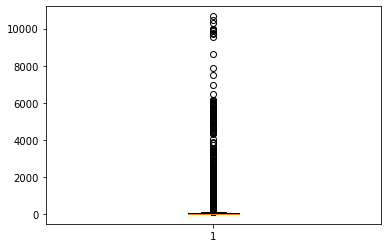

<Figure size 720x504 with 0 Axes>

In [26]:
plt.boxplot(clean_df.co2)
fig = plt.figure(figsize =(10, 7))
plt.show()

## CO2 EMISSIONS OVER THE YEARS(1950-2020)

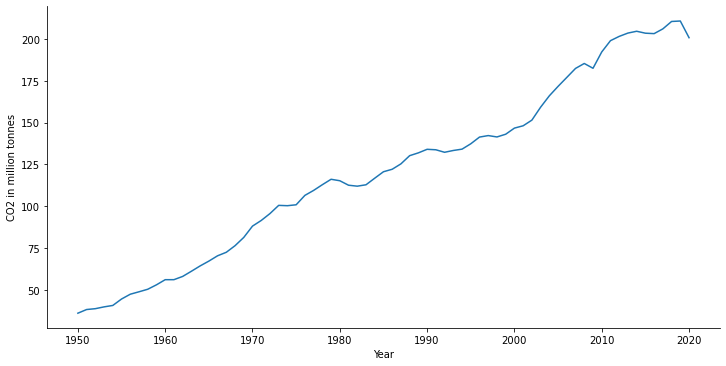

In [27]:
g = sns.relplot(
    data=clean_df, 
    x="Year", y="co2",
    height=5, aspect=2, 
    kind="line",ci=None)
g.set_axis_labels("Year", "CO2 in million tonnes")

We can infer the following details from the graph<br>

**CO2** emission has consistently increased over the last 50 years and currently shows a downward around ~2019 with a steep decrease in 2020. The steep downward trend in 2020 can be attributed due to the shutdowns from coronavirus

In [28]:
def search_code (mapdata,country):
    for keyval in mapdata:
        if country.lower() == keyval['alpha-3'].lower():
            cont = keyval['region']
    return cont

def get_continent_mapping(df,file='continent_mapping.csv'):
    col_list = ['alpha-3','region']
    mapping_data = pd.read_csv(file,usecols=col_list,sep=',')
    cont_list = []
    cont_df = df.copy()
    mapdata = mapping_data.to_json(orient = 'records')
    mapdata = json.loads(mapdata)
    for value in df['ISO3']:
        output = search_code(mapdata,value)
        if (output!= None):
            cont_list.append(output)
        else:
            cont_list.append("NA")
    cont_df['continent'] = cont_list
    return cont_df

In [29]:
continent_df = get_continent_mapping(clean_df)
continent_df.columns

Index(['ISO3', 'Year', 'CountryName', 'co2', 'population', 'co2_growth_abs',
       'share_global_co2', 'continent'],
      dtype='object')

In [30]:
col_list_cont_df = ['continent','Year','co2']
cont_df_min = continent_df[col_list_cont_df].copy()

In [31]:
cont_df_min.isna().sum()

continent    0
Year         0
co2          0
dtype: int64

In [32]:
cont_df_final = cont_df_min.groupby('continent')['co2'].sum().reset_index()

## PERCENTAGE CONTRIBUTION OF CONTINENTS FROM 1950-2020

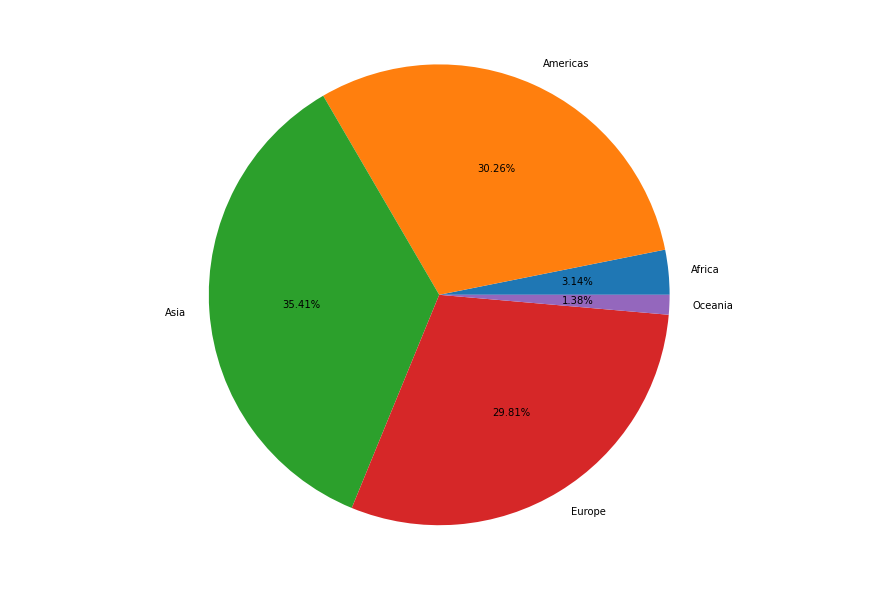

In [33]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
ax.axis('equal')
ax.pie(cont_df_final['co2'], labels = cont_df_final["continent"],autopct='%1.2f%%')
plt.show()

We can observe that in the given time period. Asia has highest CO2 emissions with Oceania consisting of Australia, Melanesia, Micronesia and Polynesia. having the least emissions

## CONTINENT WISE CONTRIBUTION IN 2020

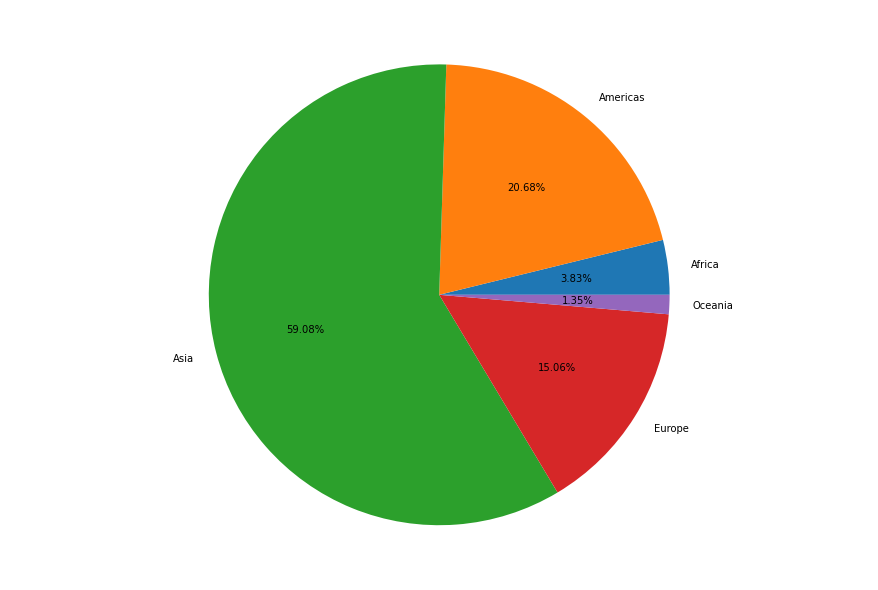

In [34]:
cont_df_final_tmp = cont_df_min[cont_df_min['Year'] == 2020]
cont_df_final_tmp = cont_df_final_tmp.groupby('continent').sum().reset_index()
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
ax.axis('equal')
ax.pie(cont_df_final_tmp['co2'], labels = cont_df_final_tmp["continent"],autopct='%1.2f%%')
plt.show()

In 2020, Asia has contributed to 60% emissions mainly attributed due to the emissions from China, India 

In [35]:
#filtering required columns
col_list=['ISO3','Year','co2']
col_list_1=['ISO3','co2']
df3 = clean_df[col_list].copy()
df4 = clean_df[col_list_1].copy()

In [36]:
#grouping by countries and getting the top 10 emitters
grouped = df4.groupby('ISO3').sum().reset_index()
sorted_top_10 = grouped.sort_values('co2', ascending=False)
top_10_co2 = sorted_top_10.iloc[:, 0]. tolist()[0:10]

In [37]:
#filtering for top 10 countries with co2 emissions
df5 = df3.copy()
df5 = df5[df5['ISO3'].isin(top_10_co2)]

## TOP 10 COUNTRIES IN CO2 EMISSIONS(1950-2020)

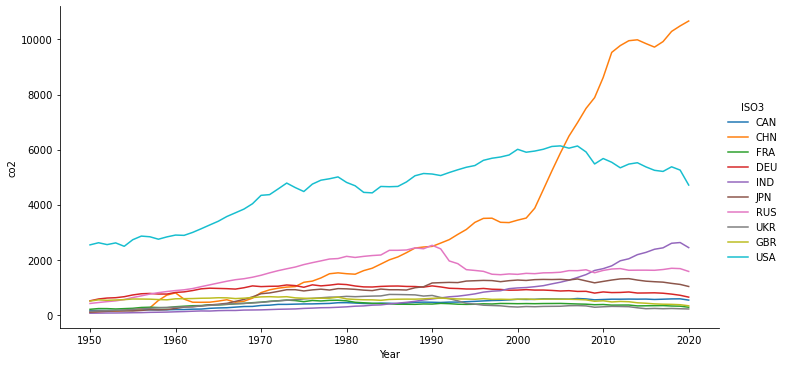

In [38]:
sns.relplot(
    data=df5, 
    x="Year", y="co2",hue='ISO3',
    height=5, aspect=2, 
    kind="line",ci=None
)

<ol>
  <li><b>USA</b> has been a top CO2 emitter during the last 50 years</li>
  <li><b>China</b> has seen an upward trend in CO2 emissions from the mid 90's due to the shift in the industrial production</li>
  <li><b>Russia</b> has been a top contributer in CO2 emissions till the 90's and there has been a downward trend since</li>
  <li><b>India's</b> contribution has also increased significantly from mid 2000's and has been an updward trend till 2020</li>
</ol>

In [39]:
# df to calculate world emissions
world_df = clean_df[['Year','co2']].copy()
world_df = world_df.groupby('Year').sum().reset_index()

## TOP 10 EMITTERS AND THE WORLD EMISSIONS IN LAST DECADE(2011-2020)

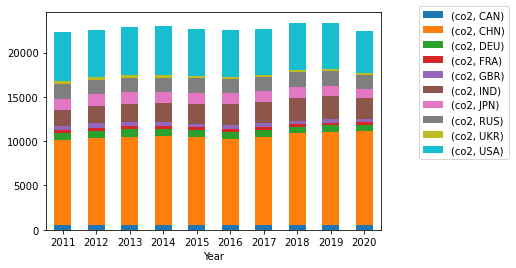

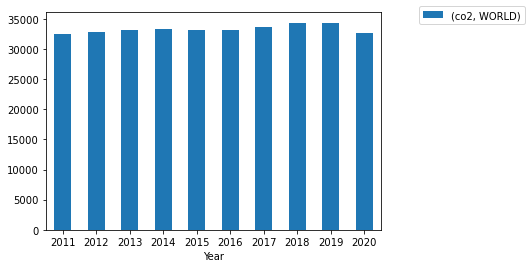

In [40]:
decade_ctr_df = df5[df5['Year'] > 2010]
g1 = decade_ctr_df.pivot(index='Year', columns='ISO3').plot(kind='bar', stacked=True, rot=0)
g1.legend(bbox_to_anchor=(1.1, 1.05))
wrld_df = world_df.copy()
wrld_df.insert(0,'ISO3','WORLD')
wrld_df = wrld_df[wrld_df['Year'] > 2010]
wrld_df
g2 = wrld_df.pivot(index='Year', columns='ISO3').plot(kind='bar', stacked=True, rot=0)
g2.legend(bbox_to_anchor=(1.1, 1.05))

We can see that the top 10 countries are contributing to a major part of the CO2 emissions

In [41]:
col_list_temp = ['ISO3','Year','co2','population']
per_captia_df = clean_df[col_list_temp].copy()
per_captia_df['co2_per_captia'] = per_captia_df['co2'] / per_captia_df['population']

In [42]:
per_captia_df.drop(['co2','population'],axis=1)
grouped_pcp = per_captia_df.groupby('ISO3').sum().reset_index()
sorted_top_10_pcp = grouped_pcp.sort_values('co2_per_captia', ascending=False)
top_10_co2_per_captia = sorted_top_10_pcp.iloc[:, 0]. tolist()[0:10]

In [43]:
df7 = per_captia_df[['ISO3','Year','co2_per_captia']].copy()
df8 = df7[df7['ISO3'].isin(top_10_co2_per_captia)]

## TOP 10 EMMITTERS BASED ON PER CAPTIA EMISSIONS

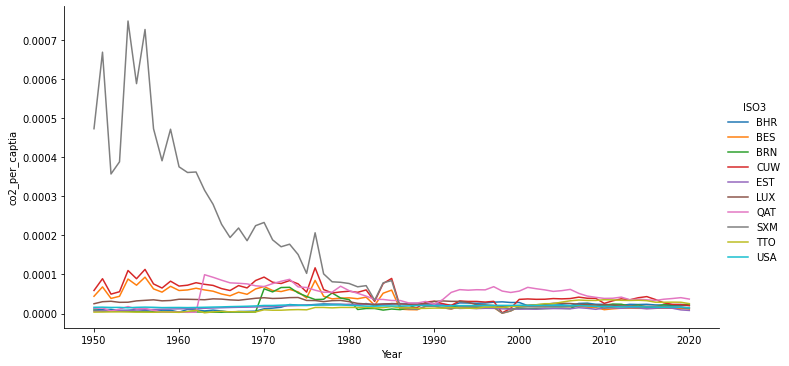

In [44]:
sns.relplot(
    data=df8, 
    x="Year", y="co2_per_captia",hue='ISO3',
    height=5, aspect=2, 
    kind="line",ci=None
)

We can observe that none of the top 10 contributors in the above chart. Since major countries have higher populations thus they have less per captia emissions<br>
Around 1970's the small country of **Sint Maarten** which is a part of Netherlands has the highest per captia emissions and has seen a downward trend since.<br>
Around the mid 90's we can see that **Kuwait** has the highest per captia emissions and has had the highest per captia emissions since then till 2020

## PERCENTAGE CHANGE OF TOP 10 CONTRIBUTORS IN LAST DECADE

In [45]:
change_df = df5[df5['Year'] >= 2010]
change_df['pct'] = change_df.sort_values('Year').groupby(['ISO3']).co2.pct_change()

<ipython-input-45-ad9e005ae188>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_df['pct'] = change_df.sort_values('Year').groupby(['ISO3']).co2.pct_change()


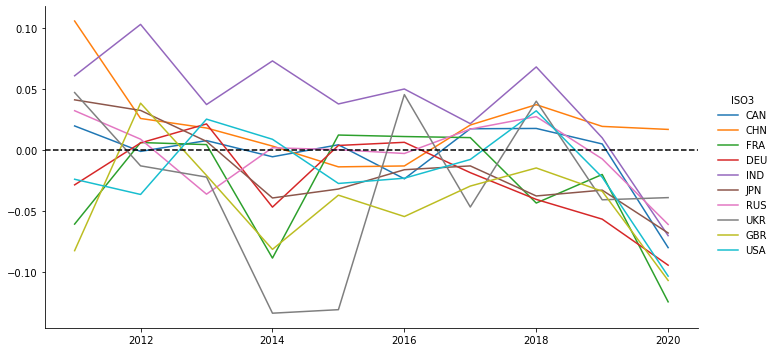

In [46]:
g3 = sns.relplot(
    data=change_df, 
    x="Year", y="pct",hue='ISO3',
    height=5, aspect=2, 
    kind="line",ci=None
)
g3.map(plt.axhline, y=0.00, ls='--', c='black')

Out of the top 10 countries except for **China** all other 9 countries have seen a decrease in their co2 emissions which can be observed due to the negative value in percentage change from ~2018

## PERCENTAGE CHANGE OF CO2 OVER YEARS(1950-2020)- WORLD DATA

In [47]:
wrld_change_df = world_df.copy()
wrld_change_df.insert(0,'ISO3','WORLD')
wrld_change_df['pct'] = wrld_change_df.sort_values('Year').groupby(['ISO3']).co2.pct_change()

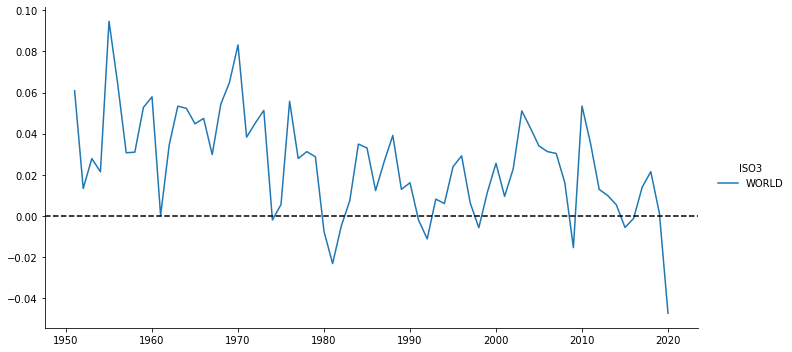

In [48]:
g4 = sns.relplot(
    data=wrld_change_df, 
    x="Year", y="pct",hue='ISO3',
    height=5, aspect=2, 
    kind="line",ci=None
)
g4.map(plt.axhline, y=0.00, ls='--', c='black')

# 4. Predictions using Linear Regression 

Linear regression is a statistical method for modeling relationships between a dependent variable with a given set of independent variables. <br>
<br>__Simple linear regression__ is an approach for predicting a response using a single feature.<br>
<br>It is assumed that the two variables are linearly related. Hence, we try to find a linear function that predicts the response value(y) as accurately as possible as a function of the feature or independent variable(x).
<br><br>
For generality, we define:<br>
x as feature vector, i.e x = [x_1, x_2, …., x_n],<br>
y as response vector, i.e y = [y_1, y_2, …., y_n]<br>
for n observations.

The equation of regression line is represented as:<br>
$$h(x_{i}) = \beta_{0} + \beta_{1}x_{i}$$


Here,  <br><br>

$h(x_{i})$ represents the predicted response value for ith observation.<br>
$\beta_{0}$ and $\beta_{1}$ are regression coefficients and represent y-intercept and slope of regression line respectively.<br><br>

To create our model, we must “learn” or estimate the values of regression coefficients $\beta_{0}$ and $\beta_{1}$. And once we’ve estimated these coefficients, we can use the model to predict responses!<br>
We will be implementing the principle of Least Squares.<br><br>
Now consider:<br><br>
$$y_{i} = \beta_{0} + \beta_{1}x_{i} + \varepsilon_{i} = h(x_{i}) + \varepsilon_{i} \Rightarrow \varepsilon_{i} = y_{i} -h(x_{i})$$<br><br>
Here, $\varepsilon_{i}$ is a residual error in ith observation. 
So, our aim is to minimize the total residual error.<br>
We define the squared error or cost function, J as: <br><br>
$$J(\beta_{0},\beta_{1})= \frac{1}{2n} \sum_{i=1}^{n} \varepsilon_{i^{2}}$$<br>
and our task is to find the value of $\beta_{0}$ and $\beta_{1}$ for which J($\beta_{0}$,$\beta_{1})$ is minimum!<br>
which can be defined as - <br><br>
$$\beta_{1} = \frac{SS_{xy}}{SS_{xx}}$$<br>
$$\beta_{0} = \bar{y} - \beta_{1}\bar{x}$$<br>
where $SS_{xy}$ is the sum of cross-deviations of y and x:<br><br>
$$SS_{xy} = \sum_{i=1}^{n} (x_{i}-\bar{x})(y_{i}-\bar{y}) = \sum_{i=1}^{n} y_{i}x_{i} - n\bar{x}\bar{y}$$<br><br>
and $SS_{xx}$ is the sum of squared deviations of x: <br><br>
$$SS_{xx} = \sum_{i=1}^{n} (x_{i}-\bar{x})^2 = \sum_{i=1}^{n}x_{i}^2 - n(\bar{x})^2$$<br>

### Multiple linear regression

Multiple linear regression attempts to model the relationship between two or more features and a response by fitting a linear equation to the observed data.<br>
Clearly, it is nothing but an extension of simple linear regression.<br>
Consider a dataset with p features(or independent variables) and one response(or dependent variable). <br>
Also, the dataset contains n rows/observations.<br>
We define:<br><br>
X (feature matrix) = a matrix of size n x p where $x_{ij}$ denotes the values of jth feature for ith observation.<br><br>
So, <br>
\begin{pmatrix} x_{11} & \cdots & x_{1p} \\ x_{21} & \cdots & x_{2p} \\ \vdots & \ddots & \vdots \\ x_{n1} & \vdots & x_{np} \end{pmatrix}<br>
and<br>
y (response vector) = a vector of size n where $y_{i}$ denotes the value of response for ith observation.<br><br>
y = \begin{bmatrix} y_1\\ y_2\\ .\\ .\\ y_n \end{bmatrix}<br><br>
The regression line for p features is represented as: <br>
$$h(x_{i}) = \beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + .... + \beta_px_{ip}$$<br><br>
where $h(x_{i})$ is predicted response value for ith observation and $\beta_{0}$, $\beta_{1}$, …, $\beta_{p}$ are the regression coefficients.<br><br>
Also, we can write: <br><br>
$$\newline y_{i} = \beta_{0} + \beta_{1}x_{i1} + \beta_{2}x_{i2} + .... + \beta_{p}x_{ip} + \varepsilon_{i} \newline$$ or $$\newline y_{i} = h(x_{i}) + \varepsilon_{i} \Rightarrow \varepsilon_{i} = y_{i} - h(x_{i})$$<br><br>
where $\varepsilon_{i}$ represents residual error in ith observation.<br>
We can generalize our linear model a little bit more by representing feature matrix X as: <br><br>
$$X = \begin{pmatrix} 1 & x_{11} & \cdots & x_{1p} \\ 1 & x_{21} & \cdots & x_{2p} \\ \vdots & \vdots & \ddots & \vdots \\ 1 & x_{n1} & \cdots & x_{np} \end{pmatrix}$$<br><br>
So now, the linear model can be expressed in terms of matrices as: <br><br>
$$y = X\beta + \varepsilon$$<br>
where, <br>
$$\beta = \begin{bmatrix} \beta_{0}\\ \beta_{1}\\ .\\ .\\ \beta_{p} \end{bmatrix}$$<br>
and<br>
$$\varepsilon = \begin{bmatrix} \varepsilon_{1}\\ \varepsilon_{2}\\ .\\ .\\ \varepsilon_{n} \end{bmatrix}$$<br><br>
Now, we determine an estimate of $\beta$, i.e. $\hat{\beta}$ using the Least Squares method.<br>
As already explained, the Least Squares method tends to determine b’ for which total residual error is minimized.<br>
We present the result directly here: <br><br>
$$\hat{\beta} = (\hat{X}X)^{-1} \hat{X}y$$<br>
where $\hat{}$ represents the transpose of the matrix while -1 represents the matrix inverse.<br>
Knowing the least square estimates, $\hat{\beta}$, the multiple linear regression model can now be estimated as:<br><br>
$$\hat{y} = X\hat{\beta}$$<br><br>
where $\hat{y}$ is the estimated response vector.<br>

In [50]:
clean_df.head()

,ISO3,Year,CountryName,co2,population,co2_growth_abs,share_global_co2
1,AFG,1950,Afghanistan,0.084,7752117.0,0.070,0.0
2,AFG,1951,Afghanistan,0.092,7840151.0,0.007,0.0
3,AFG,1952,Afghanistan,0.092,7935996.0,0.000,0.0
4,AFG,1953,Afghanistan,0.106,8039684.0,0.015,0.0
5,AFG,1954,Afghanistan,0.106,8151316.0,0.000,0.0


In [51]:
new_df = clean_df.groupby('CountryName')
final_df = [new_df.get_group(x) for x in new_df.groups]
final_df

[   ISO3  Year  CountryName     co2  population  co2_growth_abs  \
 1   AFG  1950  Afghanistan   0.084   7752117.0           0.070   
 2   AFG  1951  Afghanistan   0.092   7840151.0           0.007   
 3   AFG  1952  Afghanistan   0.092   7935996.0           0.000   
 4   AFG  1953  Afghanistan   0.106   8039684.0           0.015   
 5   AFG  1954  Afghanistan   0.106   8151316.0           0.000   
 ..  ...   ...          ...     ...         ...             ...   
 67  AFG  2016  Afghanistan   6.745  35383028.0          -1.160   
 68  AFG  2017  Afghanistan   6.860  36296111.0           0.115   
 69  AFG  2018  Afghanistan   8.345  37171922.0           1.485   
 70  AFG  2019  Afghanistan  12.147  38041757.0           3.802   
 71  AFG  2020  Afghanistan  12.160  38928341.0           0.014   
 
     share_global_co2  
 1               0.00  
 2               0.00  
 3               0.00  
 4               0.00  
 5               0.00  
 ..               ...  
 67              0.02  
 6

In [52]:
clean_df

,ISO3,Year,CountryName,co2,population,co2_growth_abs,share_global_co2
1,AFG,1950,Afghanistan,0.084,7752117.0,0.070,0.00
2,AFG,1951,Afghanistan,0.092,7840151.0,0.007,0.00
3,AFG,1952,Afghanistan,0.092,7935996.0,0.000,0.00
4,AFG,1953,Afghanistan,0.106,8039684.0,0.015,0.00
5,AFG,1954,Afghanistan,0.106,8151316.0,0.000,0.00
...,...,...,...,...,...,...,...
25199,ZWE,2016,Zimbabwe,10.738,14030338.0,-1.488,0.03
25200,ZWE,2017,Zimbabwe,9.582,14236599.0,-1.156,0.03
25201,ZWE,2018,Zimbabwe,11.854,14438812.0,2.273,0.03
25202,ZWE,2019,Zimbabwe,10.949,14645473.0,-0.905,0.03


In [53]:
clean_df.corr()

,Year,co2,population,co2_growth_abs,share_global_co2
Year,1.000000,0.094437,0.083518,-0.006355,-0.002880
co2,0.094437,1.000000,0.634882,0.428149,0.885709
population,0.083518,0.634882,1.000000,0.464794,0.527419
co2_growth_abs,-0.006355,0.428149,0.464794,1.000000,0.408351
share_global_co2,-0.002880,0.885709,0.527419,0.408351,1.000000


In [54]:
final_df[0].corr()

,Year,co2,population,co2_growth_abs,share_global_co2
Year,1.000000,0.712808,0.919561,0.192592,0.549004
co2,0.712808,1.000000,0.806822,0.362079,0.895376
population,0.919561,0.806822,1.000000,0.254920,0.590920
co2_growth_abs,0.192592,0.362079,0.254920,1.000000,0.346804
share_global_co2,0.549004,0.895376,0.590920,0.346804,1.000000


In [55]:
X = clean_df[['Year','population','co2_growth_abs','share_global_co2']]
X

,Year,population,co2_growth_abs,share_global_co2
1,1950,7752117.0,0.070,0.00
2,1951,7840151.0,0.007,0.00
3,1952,7935996.0,0.000,0.00
4,1953,8039684.0,0.015,0.00
5,1954,8151316.0,0.000,0.00
...,...,...,...,...
25199,2016,14030338.0,-1.488,0.03
25200,2017,14236599.0,-1.156,0.03
25201,2018,14438812.0,2.273,0.03
25202,2019,14645473.0,-0.905,0.03


In [56]:
X = final_df[0][['Year','population','co2_growth_abs','share_global_co2']]
X

,Year,population,co2_growth_abs,share_global_co2
1,1950,7752117.0,0.070,0.00
2,1951,7840151.0,0.007,0.00
3,1952,7935996.0,0.000,0.00
4,1953,8039684.0,0.015,0.00
5,1954,8151316.0,0.000,0.00
...,...,...,...,...
67,2016,35383028.0,-1.160,0.02
68,2017,36296111.0,0.115,0.02
69,2018,37171922.0,1.485,0.02
70,2019,38041757.0,3.802,0.03


In [57]:
y = clean_df[['co2']]
y

,co2
1,0.084
2,0.092
3,0.092
4,0.106
5,0.106
...,...
25199,10.738
25200,9.582
25201,11.854
25202,10.949


In [58]:
y = final_df[0][['co2']]
y

,co2
1,0.084
2,0.092
3,0.092
4,0.106
5,0.106
...,...
67,6.745
68,6.860
69,8.345
70,12.147


In [59]:
from sklearn.model_selection import train_test_split

from sklearn import datasets, linear_model, metrics
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=1)

In [60]:
reg = linear_model.LinearRegression()

In [61]:
reg.fit(X_train,y_train)

LinearRegression()

In [62]:
reg.coef_

array([[-3.69321890e-02,  2.47602395e-07,  1.43918288e-01,
         2.00385687e+02]])

In [63]:
reg.score(X_test,y_test)

0.9097596015142148

In [64]:
y_pred = reg.predict(X_test)

In [65]:
y_pred.shape

(29, 1)

In [66]:
y_test.shape

(29, 1)

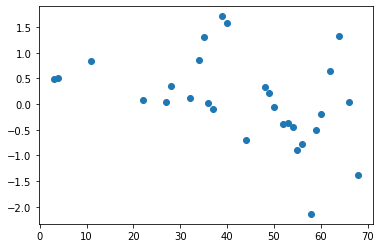

In [67]:
#plotting the difference between actual values and predicted values
g=plt.plot(y_test - y_pred,marker='o',linestyle='')

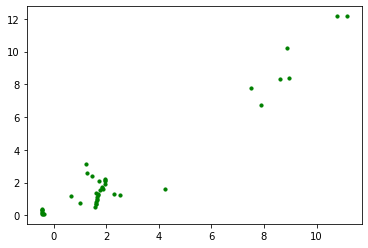

In [68]:
plt.scatter(reg.predict(X_train), y_train,
            color = "green", s = 10, label = 'Train data')

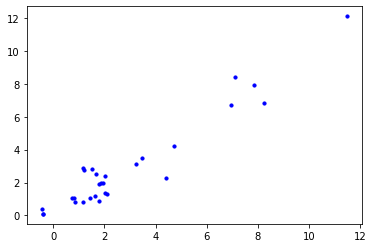

In [69]:
plt.scatter(reg.predict(X_test), y_test,
            color = "blue", s = 10, label = 'Test data')

In [70]:
reg.predict(X_test)

array([[ 7.85440909],
       [ 1.93575604],
       [ 8.24449942],
       [ 1.79299322],
       [ 2.03361851],
       [11.46104378],
       [ 0.86069848],
       [ 3.23878627],
       [ 0.81414628],
       [ 1.85993587],
       [-0.40120502],
       [ 1.19671013],
       [ 1.63300714],
       [ 3.47656719],
       [ 2.03306852],
       [ 4.40766921],
       [ 7.12281511],
       [ 1.41977492],
       [ 2.0880592 ],
       [ 0.75308823],
       [ 1.1798458 ],
       [ 1.5211289 ],
       [ 1.80941132],
       [ 6.93257674],
       [-0.41030504],
       [ 1.14778103],
       [ 1.65832011],
       [ 4.71148703],
       [-0.42978995]])

In [71]:
y_test

,co2
66,7.904
27,1.981
68,6.860
55,0.889
28,2.384
62,12.106
50,0.810
37,3.134
49,1.029
32,1.978


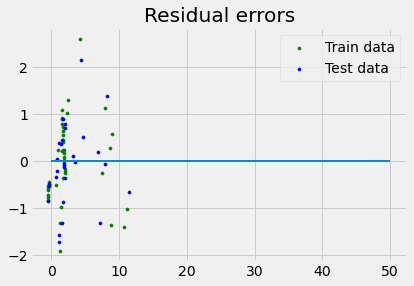

In [72]:
plt.style.use('fivethirtyeight')
 
## plotting residual errors in training data
plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train,
            color = "green", s = 10, label = 'Train data')
 
## plotting residual errors in test data
plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test,
            color = "blue", s = 10, label = 'Test data')
 
## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
 
## plotting legend
plt.legend(loc = 'upper right')
 
## plot title
plt.title("Residual errors")
 
## method call for showing the plot
plt.show()

In [73]:
import numpy as np
from sklearn import linear_model
from sklearn import svm

classifiers = [
    svm.SVR(),
    linear_model.SGDRegressor(),
    linear_model.BayesianRidge(),
    linear_model.LassoLars(),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.TheilSenRegressor(),
    linear_model.LinearRegression()]


for item in classifiers:
    print(item)
    model = item
    model.fit(X_train, y_train)
    print(model.score(X_test,y_test))
    print(model.predict(X_test),'\n')

SVR()
0.35246906404415446
[7.01571402 1.56173624 7.18459321 4.83866004 1.61343248 6.26527433
 3.49119938 1.30316249 3.3643085  1.6135204  0.68766406 1.33030315
 4.53174506 1.34461535 2.26692383 5.50963928 6.699088   4.21145185
 5.10616642 3.25342337 3.91593543 1.40037189 1.25081746 5.85089773
 0.69982174 1.27927537 1.47203222 5.6763049  0.82521303] 

SGDRegressor()
-4.4944155709041814e+44
[-9.80366017e+22 -3.68717676e+22 -1.03399460e+23 -7.04406802e+22
 -3.75218627e+22 -8.57976804e+22 -5.74620722e+22 -3.34335234e+22
 -5.62283297e+22 -3.75229589e+22 -2.26076347e+22 -3.38115451e+22
 -6.74613710e+22 -3.40090547e+22 -4.50577679e+22 -7.72032736e+22
 -9.19287783e+22 -6.43844083e+22 -7.30831691e+22 -5.51439574e+22
 -6.15533385e+22 -3.47671220e+22 -3.26907708e+22 -8.08903515e+22
 -2.29030192e+22 -3.30968851e+22 -3.57169807e+22 -7.89744734e+22
 -2.56301104e+22] 

BayesianRidge()
0.24485149927030103
[8.43725494 1.66250701 9.03137486 5.38011744 1.73446897 7.08136117
 3.94230648 1.28065858 3.80567

C:\Users\abhis\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\abhis\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\abhis\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\abhis\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

0.6291946012954226
[ 6.14095988  1.73463743  6.41937446  3.48909635  2.00216644  7.87537968
  2.82523872  2.35888078  2.8038856   2.07209943 -0.11668565  2.08149545
  3.49896704  2.74568455  2.68806319  4.71899467  5.10162122  3.38669033
  3.89990515  2.71589951  3.15728     2.09617762  1.53220987  6.16249043
 -0.06447813  1.95546988  2.14630349  5.31807796  0.29278483] 

LinearRegression()
0.9097596015142148
[[ 7.85440909]
 [ 1.93575604]
 [ 8.24449942]
 [ 1.79299322]
 [ 2.03361851]
 [11.46104378]
 [ 0.86069848]
 [ 3.23878627]
 [ 0.81414628]
 [ 1.85993587]
 [-0.40120502]
 [ 1.19671013]
 [ 1.63300714]
 [ 3.47656719]
 [ 2.03306852]
 [ 4.40766921]
 [ 7.12281511]
 [ 1.41977492]
 [ 2.0880592 ]
 [ 0.75308823]
 [ 1.1798458 ]
 [ 1.5211289 ]
 [ 1.80941132]
 [ 6.93257674]
 [-0.41030504]
 [ 1.14778103]
 [ 1.65832011]
 [ 4.71148703]
 [-0.42978995]] 



# 5. Forecasting using Naive bayes classification

Interestingly, Bernoulli Naive Bayes produced non-sensical predictions although the regressors (train_X) make much more sense to assume as categorical variables. Using Gaussian Naive Bayes was much better, probably because there is still a natural order in the regressors - that's why I recommend to experiment with a large variety of models, even though some assumptions might not be met perfectly.

In [74]:
from sklearn.metrics import mean_squared_error
from math import sqrt

X = y.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

history = [x for x in train]
predictions = list()
for i in range(len(test)):

    yhat = history[-1]
    predictions.append(yhat)
    
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=2.822, Expected=  4
>Predicted=3.501, Expected=  3
>Predicted=3.134, Expected=  3
>Predicted=3.114, Expected=  3
>Predicted=2.857, Expected=  3
>Predicted=2.765, Expected=  3
>Predicted=2.603, Expected=  2
>Predicted=2.427, Expected=  1
>Predicted=1.379, Expected=  1
>Predicted=1.333, Expected=  1
>Predicted=1.282, Expected=  1
>Predicted=1.230, Expected=  1
>Predicted=1.165, Expected=  1
>Predicted=1.084, Expected=  1
>Predicted=1.029, Expected=  1
>Predicted=0.810, Expected=  1
>Predicted=0.758, Expected=  1
>Predicted=0.798, Expected=  1
>Predicted=1.052, Expected=  1
>Predicted=1.186, Expected=  1
>Predicted=0.889, Expected=  1
>Predicted=1.303, Expected=  2
>Predicted=1.635, Expected=  2
>Predicted=2.269, Expected=  4
>Predicted=4.200, Expected=  7
>Predicted=6.740, Expected=  8
>Predicted=8.398, Expected= 12
>Predicted=12.106, Expected= 10
>Predicted=10.219, Expected=  8
>Predicted=8.441, Expected=  8
>Predicted=7.774, Expected=  8
>Predicted=7.904, Expected=  7
>Predi

# 6. Forecatsing using Random Forest Regressor

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [76]:
print(final_df[0].columns)
print(final_df[0].shape)
rf_df = final_df[0]
print(rf_df.head())

Index(['ISO3', 'Year', 'CountryName', 'co2', 'population', 'co2_growth_abs',
       'share_global_co2'],
      dtype='object')
(71, 7)
  ISO3  Year  CountryName    co2  population  co2_growth_abs  share_global_co2
1  AFG  1950  Afghanistan  0.084   7752117.0           0.070               0.0
2  AFG  1951  Afghanistan  0.092   7840151.0           0.007               0.0
3  AFG  1952  Afghanistan  0.092   7935996.0           0.000               0.0
4  AFG  1953  Afghanistan  0.106   8039684.0           0.015               0.0
5  AFG  1954  Afghanistan  0.106   8151316.0           0.000               0.0


In [77]:
 # Shift close down to predict next day
rf_df=pd.concat([rf_df.population, rf_df.co2.shift(-10),rf_df.co2_growth_abs, rf_df.share_global_co2 ], axis=1)

In [78]:
rf_df

,population,co2,co2_growth_abs,share_global_co2
1,7752117.0,0.414,0.070,0.00
2,7840151.0,0.491,0.007,0.00
3,7935996.0,0.689,0.000,0.00
4,8039684.0,0.707,0.015,0.00
5,8151316.0,0.839,0.000,0.00
...,...,...,...,...
67,35383028.0,NaN,-1.160,0.02
68,36296111.0,NaN,0.115,0.02
69,37171922.0,NaN,1.485,0.02
70,38041757.0,NaN,3.802,0.03


In [79]:
def valid(col):
     return 'co2' not in col
# we remove the last observation (last row) because there is no tomorrow for the last row to predict!
rf_X = rf_df[[x for x in rf_df.columns if valid(x)]].iloc[:-10]
#rf_X.drop([ISO3])

# for the dependent variable, we remove the NA, so that removes the last row, too
rf_y = rf_df.co2.dropna()


In [80]:
rf_X.T

,1,2,3,4,5,6,7,8,9,10,...,52,53,54,55,56,57,58,59,60,61
population,7752117.0,7840151.0,7935996.0,8039684.0,8151316.0,8270992.0,8398873.0,8535157.0,8680097.0,8833947.0,...,21606992.0,22600774.0,23680871.0,24726689.0,25654274.0,26433058.0,27100542.0,27722281.0,28394806.0,29185511.0


In [81]:
rf_y

1      0.414
2      0.491
3      0.689
4      0.707
5      0.839
       ...  
57     6.745
58     6.860
59     8.345
60    12.147
61    12.160
Name: co2, Length: 61, dtype: float64

In [82]:
X_train, X_test, y_train, y_test = train_test_split(rf_X, rf_y, random_state=42)

In [83]:
# Create a model 
rf_model = RandomForestRegressor()

In [84]:
# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [85]:
# Get R2 measure (indicator of accuracy 1 is perfect, 0 is horrible)
rf_model.score(X_test, y_test)

0.8839335244044995

In [86]:
y_pred = rf_model.predict(X_test)

In [87]:
type(y_pred)

numpy.ndarray

In [88]:
y_pred[0:10]

array([0.62058, 0.96789, 2.25092, 2.65   , 1.90372, 7.08733, 2.41545,
       5.13897, 1.82065, 2.85568])

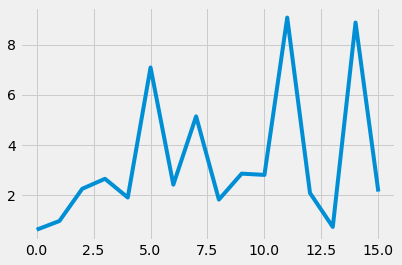

In [89]:
import matplotlib.pyplot as plt
plt.plot(y_pred)

In [90]:
type(y_test)

pandas.core.series.Series

In [91]:
y_test2 = y_test.values
type(y_test2)

numpy.ndarray

In [92]:
y_test2[0:10]

array([0.414, 1.007, 1.635, 2.427, 1.635, 7.904, 1.282, 6.74 , 1.53 ,
       0.758])

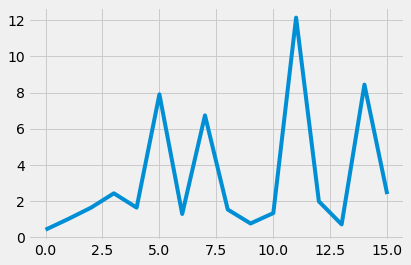

In [93]:
import matplotlib.pyplot as plt
plt.plot(y_test2)

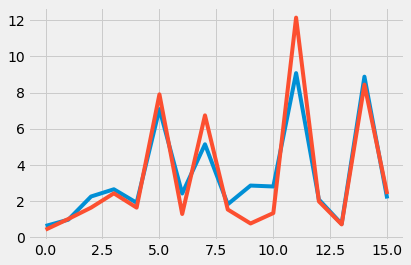

In [94]:
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.plot(y_test2)

In [96]:
pd.concat([pd.Series(y_pred), y_test.reset_index(drop=True)], axis=1)

,0,co2
0,0.62058,0.414
1,0.96789,1.007
2,2.25092,1.635
3,2.65000,2.427
4,1.90372,1.635
5,7.08733,7.904
6,2.41545,1.282
7,5.13897,6.740
8,1.82065,1.530
9,2.85568,0.758


In [97]:
final_df[68].head()

,ISO3,Year,CountryName,co2,population,co2_growth_abs,share_global_co2
10907,IND,1950,India,61.177,376325200.0,4.912,1.02
10908,IND,1951,India,64.100,382376945.0,2.922,1.00
10909,IND,1952,India,67.509,388799076.0,3.409,1.04
10910,IND,1953,India,68.789,395544365.0,1.280,1.03
10911,IND,1954,India,72.500,402578594.0,3.711,1.07


(71, 7)
10
(61, 1)
(61,)
[ 128.14946  147.30838 1230.91107  595.77616  210.95772 2323.21994
  741.80834 1631.756    192.78528  958.47068]


,0,co2
0,128.14946,111.450
1,147.30838,153.868
2,1230.91107,1259.744
3,595.77616,615.925
4,210.95772,209.291
5,2323.21994,2268.567
6,741.80834,716.918
7,1631.75600,1612.817
8,192.78528,203.227
9,958.47068,978.919


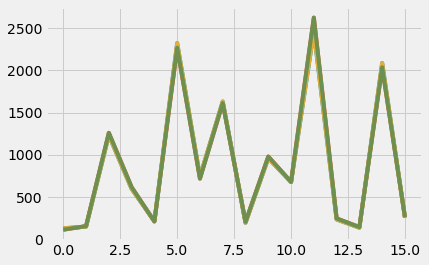

In [99]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
rf_ind = final_df[68]
print(rf_ind.shape)
# Shift close down to predict next day
rf_ind=pd.concat([rf_ind.population, rf_ind.co2.shift(-10),rf_ind.co2_growth_abs, rf_ind.share_global_co2 ], axis=1)
def valid(col): return 'co2' not in col
# we remove the last observation (last row) because there is no tomorrow for the last row to predict!
rf_ind_X = rf_ind[[x for x in rf_df.columns if valid(x)]].iloc[:-10]
print(rf_ind.co2.isna().sum())
print(rf_ind_X.shape)
# for the dependent variable, we remove the NA, so that removes the last row, too
rf_ind_y = rf_ind.co2.dropna()
print(rf_ind_y.shape)
X_train, X_test, y_train, y_test = train_test_split(rf_ind_X, rf_ind_y, random_state=42)
# Create a model
rf_model = RandomForestRegressor()
# Train the model
rf_model.fit(X_train, y_train)
# Get R2 measure (indicator of accuracy 1 is perfect, 0 is horrible)
rf_model.score(X_test, y_test)
y_pred = rf_model.predict(X_test)
print(y_pred[0:10])
import matplotlib.pyplot as plt
plt.plot(y_pred)
y_test2 = y_test.values
type(y_test2)
import matplotlib.pyplot as plt
plt.plot(y_test2)
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.plot(y_test2)
pd.concat([pd.Series(y_pred), y_test.reset_index(drop=True)], axis=1)

(71, 7)
10
(61, 1)
(61,)
[2948.65968 3369.12957 6127.49214 5128.64605 4555.02598 5424.39152
 5385.23281 5717.85984 4435.21873 5833.9017 ]


,0,co2
0,2948.65968,2897.138
1,3369.12957,3399.342
2,6127.49214,6051.668
3,5128.64605,5057.931
4,4555.02598,4784.823
5,5424.39152,5371.771
6,5385.23281,5358.824
7,5717.85984,5478.210
8,4435.21873,4572.791
9,5833.90170,6010.508


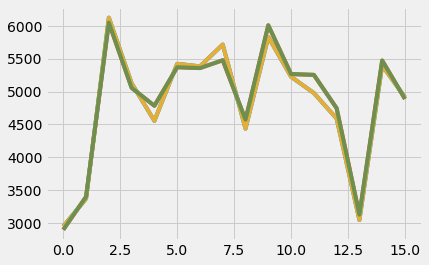

In [100]:
rf_usa = final_df[155]
print(rf_usa.shape)
# Shift close down to predict next day
rf_usa=pd.concat([rf_usa.population, rf_usa.co2.shift(-10),rf_usa.co2_growth_abs, rf_usa.share_global_co2 ], axis=1)



def valid(col): return 'co2' not in col
# we remove the last observation (last row) because there is no tomorrow for the last row to predict!
rf_usa_X = rf_usa[[x for x in rf_df.columns if valid(x)]].iloc[:-10]



print(rf_usa.co2.isna().sum())
print(rf_usa_X.shape)
# for the dependent variable, we remove the NA, so that removes the last row, too
rf_usa_y = rf_usa.co2.dropna()
print(rf_usa_y.shape)
X_train, X_test, y_train, y_test = train_test_split(rf_usa_X, rf_usa_y, random_state=42)
# Create a model
rf_model = RandomForestRegressor()
# Train the model
rf_model.fit(X_train, y_train)
# Get R2 measure (usaicator of accuracy 1 is perfect, 0 is horrible)
rf_model.score(X_test, y_test)
y_pred = rf_model.predict(X_test)
print(y_pred[0:10])
import matplotlib.pyplot as plt
plt.plot(y_pred)
y_test2 = y_test.values
type(y_test2)
import matplotlib.pyplot as plt
plt.plot(y_test2)
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.plot(y_test2)
pd.concat([pd.Series(y_pred), y_test.reset_index(drop=True)], axis=1)

(71, 7)
10
(61, 1)
(61,)
[2973.16566 3372.0685  6125.03258 5123.86659 4556.04838 5434.57499
 5378.07344 5724.60532 4429.75657 5825.76496]


,0,co2
0,2973.16566,2897.138
1,3372.06850,3399.342
2,6125.03258,6051.668
3,5123.86659,5057.931
4,4556.04838,4784.823
5,5434.57499,5371.771
6,5378.07344,5358.824
7,5724.60532,5478.210
8,4429.75657,4572.791
9,5825.76496,6010.508


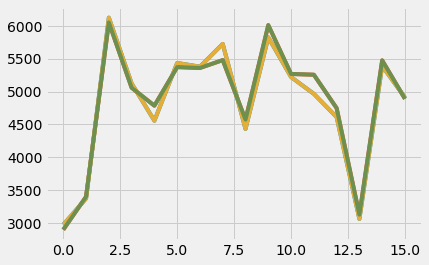

In [103]:
rf_chn = final_df[155]
print(rf_chn.shape)
# Shift close down to predict next day
rf_chn=pd.concat([rf_chn.population, rf_chn.co2.shift(-10),rf_chn.co2_growth_abs, rf_chn.share_global_co2 ], axis=1)


def valid(col): return 'co2' not in col
# we remove the last observation (last row) because there is no tomorrow for the last row to predict!
rf_chn_X = rf_chn[[x for x in rf_df.columns if valid(x)]].iloc[:-10]



print(rf_chn.co2.isna().sum())
print(rf_chn_X.shape)
# for the dependent variable, we remove the NA, so that removes the last row, too
rf_chn_y = rf_chn.co2.dropna()
print(rf_chn_y.shape)
rf_chn_y = rf_chn.co2.dropna()


X_train, X_test, y_train, y_test = train_test_split(rf_chn_X, rf_chn_y, random_state=42)
# Create a model
rf_model = RandomForestRegressor()
# Train the model
rf_model.fit(X_train, y_train)
# Get R2 measure (canicator of accuracy 1 is perfect, 0 is horrible)
rf_model.score(X_test, y_test)
y_pred = rf_model.predict(X_test)
print(y_pred[0:10])
import matplotlib.pyplot as plt
plt.plot(y_pred)
y_test2 = y_test.values
type(y_test2)
import matplotlib.pyplot as plt
plt.plot(y_test2)
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.plot(y_test2)
pd.concat([pd.Series(y_pred), y_test.reset_index(drop=True)], axis=1)

# 7. Conclusion 
As can be seen the overall CO2 emissions for entire world is consistently increasing and we can observe this from the percentage change graph for CO2 emissions.<br>
We observe a slight dip in CO2 during the year 2015 but it wasn't maintained consistently indicating that the countries are not focusing reducing the carbon footprint over the world.<br>
However, in the year 2020 there is a steep fall in CO2 emissions that can be inferenced due to the pandemic situation and is the highest dip in CO2 emissions world has ever observed!!<br>
Overall the countries needs to take measure to curb the CO2 emissions if we are meet the Paris Climate Agreement goals.
While predicting the overall CO2 emissions for the world we have used different approaches to predict the data both using classification technique and Regression models as well.<br>
We were able to achieve an accuracy of  using Naive-Bayes Classification technique. And using different Regression algorithms we observed an accuracy of 96 % for RandomForest, 90% for Linear Regression, 64% for TheilSenRegression and 87% for ARDRegression.

# 8. Future Scope
This model can be extended for other greenhouse gas emissions and pollution data.<br>
Currently we have generalized visualizations and modeling the data for all countries  together, it would be good to have specific analysis for each country based on their emission rate<br>
We could also explore more advanced machine learning models such as ARIMA, Neural networks and increase the dataset scope by including monthly data for last 70 years.<br>